In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.utils import shuffle
from scipy import stats

In [2]:
data = pd.read_csv('/Users/_fangkhai/Documents/Computer Science Semester 5/Introduction to Data Science/Assignment Dataset/INFY Historical Data.csv').fillna(0)
data["Date"] = pd.to_datetime(data.Date)
data.set_index ("Date", inplace = True)

In [3]:
data.dtypes

Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3968 entries, 2020-12-31 to 2005-01-03
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     3968 non-null   object
 1   Open      3968 non-null   object
 2   High      3968 non-null   object
 3   Low       3968 non-null   object
 4   Vol.      3968 non-null   object
 5   Change %  3968 non-null   object
dtypes: object(6)
memory usage: 217.0+ KB


In [5]:
data["Price"] = data["Price"].str.replace(",", "")
data["Open"] = data["Open"].str.replace(",", "")
data["High"] = data["High"].str.replace(",", "")
data["Low"] = data["Low"].str.replace(",", "")
data["Vol."] = data["Vol."].str.replace("M", "")
data["Change %"] = data["Change %"].str.replace("%", "")

In [6]:
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')
data['Open'] = pd.to_numeric(data['Open'], errors='coerce')
data['High'] = pd.to_numeric(data['High'], errors='coerce')
data['Low'] = pd.to_numeric(data['Low'], errors='coerce')
data['Vol.'] = pd.to_numeric(data['Vol.'], errors='coerce')
data['Change %'] = pd.to_numeric(data['Change %'], errors='coerce')

In [7]:
data.isnull().sum()

Price        0
Open         0
High         0
Low          0
Vol.        19
Change %     0
dtype: int64

In [8]:
data.dtypes

Price       float64
Open        float64
High        float64
Low         float64
Vol.        float64
Change %    float64
dtype: object

In [9]:
data = data.fillna(data["Vol."].mean())

In [10]:
data.isnull().sum()

Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [11]:
z = np.abs(stats.zscore(data))
(np.abs(stats.zscore(data)) > 3).sum()

Price       61
Open        60
High        61
Low         59
Vol.        53
Change %    60
dtype: int64

In [12]:
(np.abs(stats.zscore(data)) > 3).sum()

Price       61
Open        60
High        61
Low         59
Vol.        53
Change %    60
dtype: int64

In [13]:
data_clean = data[((np.abs(stats.zscore(data)))<3).all(axis=1)]
data_clean

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-10-01,1017.65,1020.60,1026.50,1011.75,5.56,0.93
2020-09-30,1008.25,1009.00,1023.95,1005.00,8.05,-0.07
2020-09-29,1009.00,1018.00,1028.00,1004.10,8.71,-0.14
2020-09-28,1010.40,1014.80,1016.15,998.50,8.55,-0.10
2020-09-25,1011.45,975.80,1014.90,975.00,13.31,3.70
...,...,...,...,...,...,...
2005-01-07,127.17,126.19,128.05,123.71,33.50,0.35
2005-01-06,126.73,126.58,129.85,123.90,27.03,-0.43
2005-01-05,127.28,128.05,128.98,124.09,22.20,-1.79


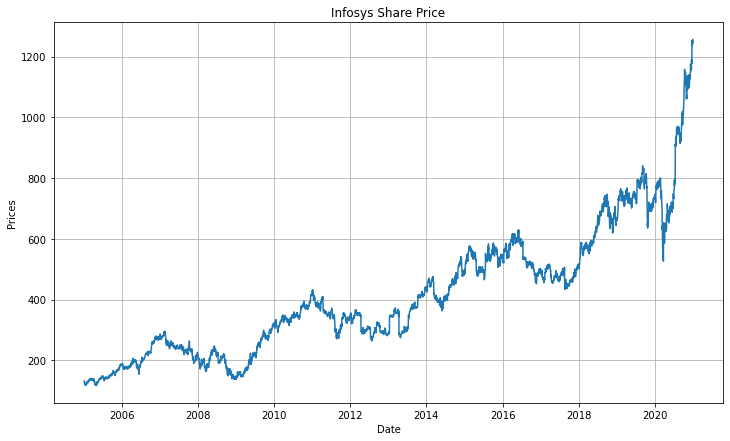

In [14]:
plt.figure(figsize=(12,7))
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Prices")
plt.plot(data["Price"])
plt.title("Infosys Share Price")
plt.show()

<AxesSubplot:ylabel='Density'>

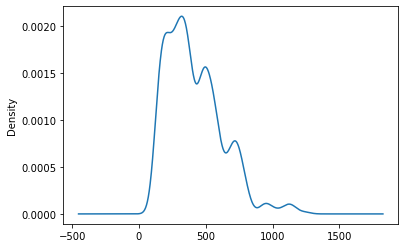

In [15]:
df = data["Price"]
df.plot(kind = "kde")

### Determine MA (Parameter q)

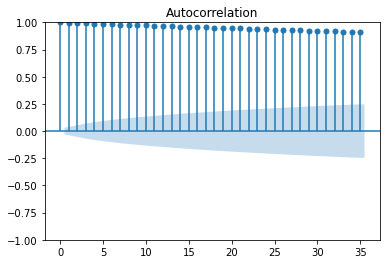

In [16]:
plot_acf(data["Price"], lags = 35)
plt.show()

### Determine AR (Parameter p)

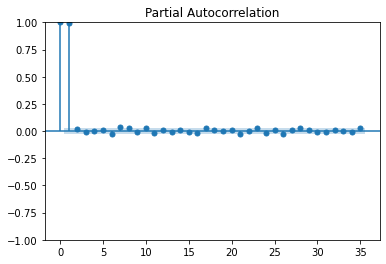

In [17]:
plot_pacf(data["Price"], lags = 35)
plt.show()

### SelectKBest

In [18]:
open_price_crosstab = pd.crosstab(data["Open"], data["Price"], margins = True)
open_price_crosstab

Price,117.0,117.91,118.16,118.17,118.21,118.6,118.62,118.68,118.7,118.76,...,1177.3,1189.8,1220.5,1236.05,1240.3,1246.8,1250.3,1253.05,1255.8,All
Open,,,,,,,,,,,,,,,,,,,,,
117.63,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
117.82,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
118.38,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
118.44,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
118.75,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1238.45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1243.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1249.9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [19]:
high_price_crosstab = pd.crosstab(data["High"], data["Price"], margins = True)
high_price_crosstab

Price,117.0,117.91,118.16,118.17,118.21,118.6,118.62,118.68,118.7,118.76,...,1177.3,1189.8,1220.5,1236.05,1240.3,1246.8,1250.3,1253.05,1255.8,All
High,,,,,,,,,,,,,,,,,,,,,
118.75,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
119.0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
119.18,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
119.37,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
119.99,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1254.45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1258.4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [20]:
low_price_crosstab = pd.crosstab(data["Low"], data["Price"], margins = True)
low_price_crosstab

Price,117.0,117.91,118.16,118.17,118.21,118.6,118.62,118.68,118.7,118.76,...,1177.3,1189.8,1220.5,1236.05,1240.3,1246.8,1250.3,1253.05,1255.8,All
Low,,,,,,,,,,,,,,,,,,,,,
116.28,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
116.36,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
116.45,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
116.7,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
117.2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1236.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1238.15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [21]:
vol_price_crosstab = pd.crosstab(data["Vol."], data["Price"], margins = True)
vol_price_crosstab

Price,117.0,117.91,118.16,118.17,118.21,118.6,118.62,118.68,118.7,118.76,...,1177.3,1189.8,1220.5,1236.05,1240.3,1246.8,1250.3,1253.05,1255.8,All
Vol.,,,,,,,,,,,,,,,,,,,,,
1.09,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1.23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1.42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1.48,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1.7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92.85,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
98.03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
164.4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [22]:
change_price_crosstab = pd.crosstab(data["Change %"], data["Price"], margins = True)
change_price_crosstab

Price,117.0,117.91,118.16,118.17,118.21,118.6,118.62,118.68,118.7,118.76,...,1177.3,1189.8,1220.5,1236.05,1240.3,1246.8,1250.3,1253.05,1255.8,All
Change %,,,,,,,,,,,,,,,,,,,,,
-21.26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
-16.19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
-13.4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
-12.66,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
-10.04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11.13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12.03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13.02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [25]:
shuffled_data = shuffle(data, random_state = 800)

#X = Independent Variable
target_col = "Price"
X = data.drop("Price", axis = 1)

#y = Dependent Variable
y = shuffled_data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 800)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3174, 5) (794, 5) (3174,) (794,)


In [27]:
X_n = SelectKBest(f_classif, k = 1).fit_transform(X, y)
X_new = SelectKBest(f_classif, k = 1).fit(X_train, y_train)
X_train.columns[X_new.get_support()]

Index(['Low'], dtype='object')

In [28]:
pd.crosstab(np.squeeze(X_n), np.squeeze(y))

Price,117.00,117.91,118.16,118.17,118.21,118.60,118.62,118.68,118.70,118.76,...,1175.20,1177.30,1189.80,1220.50,1236.05,1240.30,1246.80,1250.30,1253.05,1255.80
row_0,,,,,,,,,,,,,,,,,,,,,
116.28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116.36,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116.45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116.70,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117.20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230.55,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1235.00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1236.00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


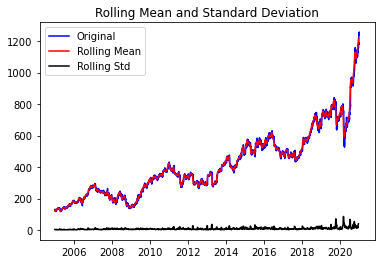

Results of dickey fuller test
Test Statistics                  -3.553030
p-value                           0.006725
No. of lags used                 26.000000
Number of observations used    3941.000000
critical value (1%)              -3.432010
critical value (5%)              -2.862274
critical value (10%)             -2.567161
dtype: float64


In [29]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #Perform dickey fuller test
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(data["Price"])

In [30]:
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

In [31]:
stepwise_fit = auto_arima(data["Low"], trace=True, suppress_warning=True)
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=27680.877, Time=2.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27681.827, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27677.039, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=27676.891, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27684.765, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=27677.697, Time=0.79 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=27678.463, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=27678.945, Time=1.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=27679.440, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 5.544 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3968
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -13835.446
Date:                Tue, 18 Apr 2023   

In [32]:
#For 15 Years
model = sm.tsa.arima.ARIMA(data["Low"], order = (0, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    Low   No. Observations:                 3968
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -13837.720
Date:                Tue, 18 Apr 2023   AIC                          27679.440
Time:                        20:50:33   BIC                          27692.012
Sample:                             0   HQIC                         27683.899
                               - 3968                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0434      0.008      5.502      0.000       0.028       0.059
sigma2        62.7110      0.352    178.073      0.000      62.021      63.401
Ljung-Box (L1) (Q):                   0.01   Jarque-

/Users/_fangkhai/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/_fangkhai/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/_fangkhai/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/_fangkhai/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  

### Predict

In [33]:
start = len(train)
end = len(train) + len(test) - 1
predictions = model_fit.predict(start=start, end=end)
predictions

Date
2008-02-29    180.044017
2008-02-28    189.002409
2008-02-27    197.826840
2008-02-26    200.417705
2008-02-25    199.637569
                 ...    
2005-01-07    122.911108
2005-01-06    123.744651
2005-01-05    123.906738
2005-01-04    124.097949
2005-01-03    129.191755
Name: predicted_mean, Length: 794, dtype: float64

In [34]:
s = pd.Series(predictions, index = data.index[-150:]) 
s

Date
2005-08-04    141.241466
2005-08-03    142.898901
2005-08-02    143.254795
2005-08-01    140.046634
2005-07-29    136.398337
                 ...    
2005-01-07    122.911108
2005-01-06    123.744651
2005-01-05    123.906738
2005-01-04    124.097949
2005-01-03    129.191755
Name: predicted_mean, Length: 150, dtype: float64

<AxesSubplot:xlabel='Date'>

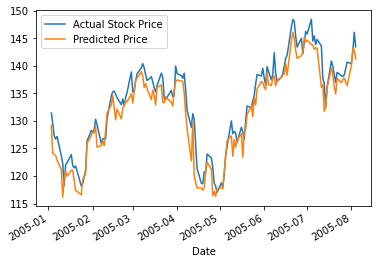

In [35]:
data["Price"][-150:].plot(label = "Actual Stock Price", legend = True)
s.plot(label = "Predicted Price", legend = True)

In [36]:
mape = np.mean(np.abs((test["Price"] - predictions) / test["Price"])) * 100
mape

1.5268174983370786

In [37]:
mae = mean_absolute_error(test["Price"], predictions)
mae

3.057579650722498

In [40]:
mse = mean_squared_error(test["Price"], predictions)
mse

19.879037505807272

In [39]:
rmse = math.sqrt(mse)
rmse

4.4585914262025925